# Advanced Model-Free Control of Engineered Cells

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import pytorch_drl as drl

## Global Variants

In [2]:
SEED = 0
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
torch.manual_seed(SEED)

## Define Environment with Discrete Action Space

In [264]:
# reference trajectory
REF_INTENSITY = 1.8


# CRN environment
ENV = 'CRN-v0'

SAMPLING_RATE= 30#10  # in minutes

OBSERVATION_NOISE = 0#0.05#0.05
ACTION_NOISE = 0#0.05#0.01
SYSTEM_NOISE = 0#0.01#1e-3

d_r = 0.0956
d_p = 0.0214
k_m = 0.0116
b_r = 0.0965
THETA = [d_r, d_p, k_m, b_r]

PERCENTAGE_THRES = 30 # in percentage

MODE = 'partially_observed'#'fully_observed'#

EXTRA_INFO = False#True


# CRN step
SAMPLING_STEPS = 60  # 10 hours
REWARD_FUNC = 'negative_logae'

* Constant reference trajectory

In [265]:
ref_trajectory = drl.env.crn.ConstantRefTrajectory(
    scale=REF_INTENSITY,
)

* Define CRN environment with discrete action space `CRN-v0`

In [266]:
env = drl.env.CRNEnv(
    ENV,
    DEVICE,
    ref_trajectory=ref_trajectory,
    sampling_rate=SAMPLING_RATE,
    observation_noise=OBSERVATION_NOISE,
    action_noise=ACTION_NOISE,
    system_noise=SYSTEM_NOISE,
    theta=THETA,
    percentage_thres=PERCENTAGE_THRES,
    observation_mode=MODE,
    extra_info=EXTRA_INFO,
)

In [255]:
env.seed(SEED)

In [8]:
env.reset()

for _ in range(SAMPLING_STEPS):
    env.step(
        env.action_sample(), 
        reward_func=REWARD_FUNC,
    )

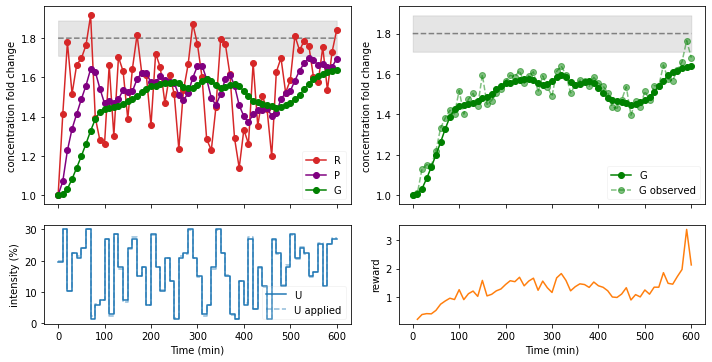

In [9]:
env.render(render_mode='dashboard')

## Constantly Applied Light Intensity in Discrete Action Space

In [10]:
# training
EPISODES = 100
TIMESTEPS = 60  # 10 hours

REWARD_FUNC = 'scaled_se'#'negative_logae'

# replay
EPISODE = -1

### Constant Agent

* Define constant agent for discrete action space

In [11]:
actor = drl.nn.ConstantActor(
    env.action_dim,
    19,
)

agent = drl.agent.DummyAgent(
    DEVICE,
    actor,
)

### Trainer for Constant Agent

In [12]:
trainer = drl.trainer.OffPolicyTrainer(
    env, 
    agent,
    n_episodes=EPISODES,
    n_timesteps=TIMESTEPS,
)

### Constantly Applying

In [13]:
logger = trainer(REWARD_FUNC)

### Replay

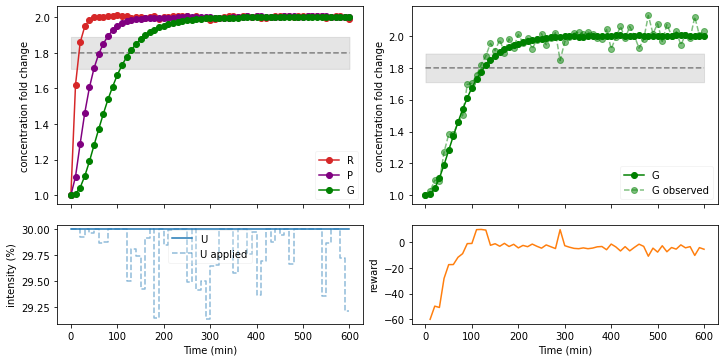

In [14]:
drl.utils.plotter.replay(env, logger, EPISODE)

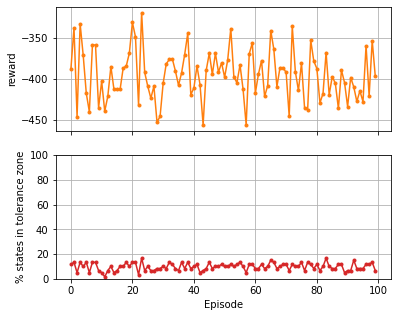

In [15]:
logger.plot()

### Evaluate

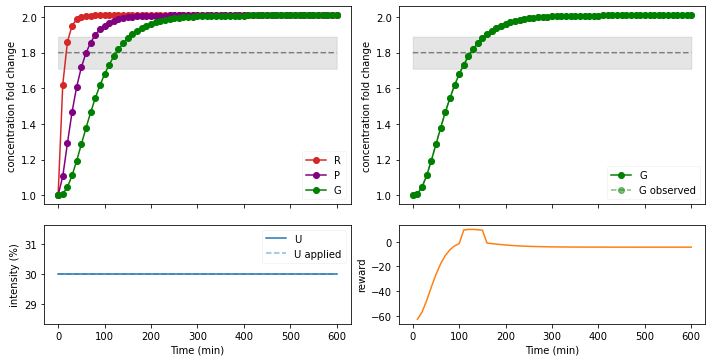

In [14]:
trainer.evaluate()

## Random Walking in Discrete Action Space

In [15]:
# training
EPISODES = 100
TIMESTEPS = 60  # 10 hours

REWARD_FUNC = 'negative_sqrtre'#'scaled_se'#'negative_logae'

# replay
EPISODE = -1

### Random Agent

* Define random agent for discrete action space

In [16]:
actor = drl.nn.RandomActor(
    env.action_dim,
)

agent = drl.agent.DummyAgent(
    DEVICE,
    actor,
)

### Trainer for Random Agent

In [17]:
trainer = drl.trainer.OffPolicyTrainer(
    env, 
    agent,
    n_episodes=EPISODES,
    n_timesteps=TIMESTEPS,
)

### Random Walking

In [18]:
logger = trainer(REWARD_FUNC)

### Replay

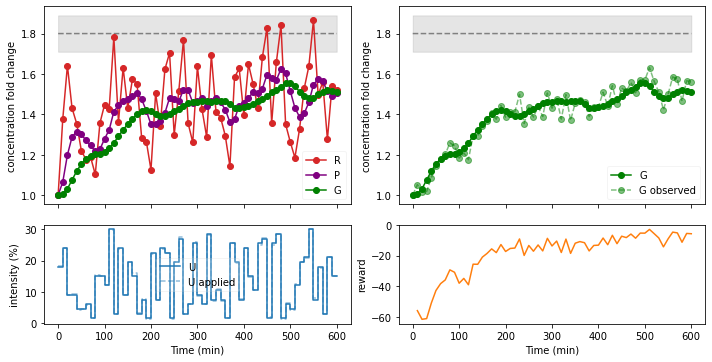

In [21]:
drl.utils.plotter.replay(env, logger, EPISODE)

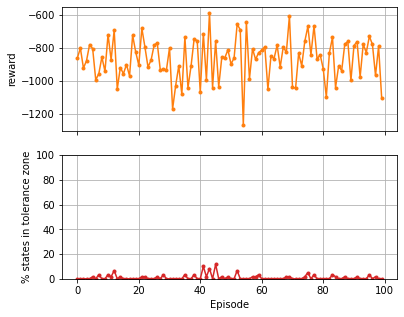

In [22]:
logger.plot()

### Evaluation

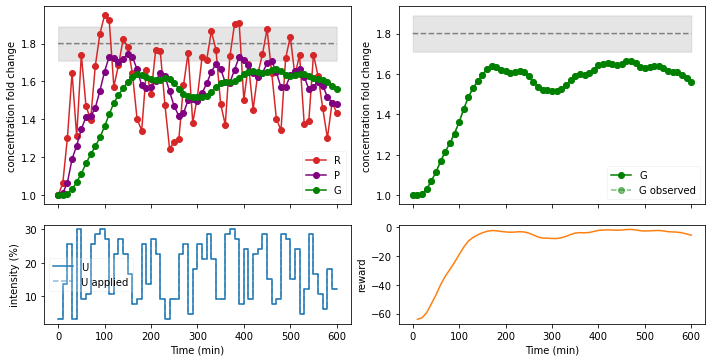

In [19]:
trainer.evaluate()

## Control with Q-Learning Agent for Discrete Action Space

In [267]:
# training
EPISODES = 100
TIMESTEPS = 60  # 10 hours

REWARD_FUNC = 'inverse_ae'#'scaled_se'##'negative_logae'#'negative_sqrtre'#

# replay
EPISODE = -1

### Agents

* DQN agent

In [257]:
actor = drl.nn.RandomActor(
    env.action_dim,
)

critic = drl.nn.QCritic(
    env.state_dim,
    env.action_dim,
)

agent = drl.agent.DQNAgent(
    DEVICE,
    actor,
    critic,
    exploration_rate=0.9,
    batch_size=128,
    burnin_size=16,
    learn_every=1,
    sync_every=4,
)

* DDQN agent

In [268]:
actor = drl.nn.RandomActor(
    env.action_dim,
)

critic = drl.nn.TwinQCritic(
    env.state_dim,
    env.action_dim,
    approximator_dims=(256,),
    param_sharing=False,
    hidden_dim=256,
    embedding_dims=(256,),
)

agent = drl.agent.DDQNAgent(
    DEVICE,
    actor,
    critic,
    exploration_rate=0.9,
    batch_size=128,
    burnin_size=16,
    learn_every=1,
    sync_every=2,
)

### Off-Policy Trainer for Q-learning Agent

* Define trainer for DQN family

In [269]:
bs_scheduler = drl.utils.bs_scheduler.ConstantBS(
    agent,
)

er_scheduler = drl.utils.er_scheduler.ExponentialER(
    agent,
    decay_coefficient=200,
    end_er=0.05,
)

trainer = drl.trainer.OffPolicyTrainer(
    env, 
    agent,
    n_episodes=EPISODES,
    n_timesteps=TIMESTEPS,
    bs_scheduler=bs_scheduler,
    er_scheduler=er_scheduler,
)

### Training

In [270]:
logger = trainer(REWARD_FUNC)

### Replay

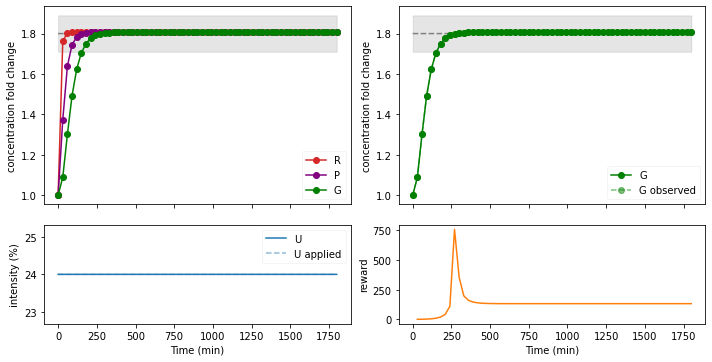

In [271]:
drl.utils.plotter.replay(env, logger, -1)

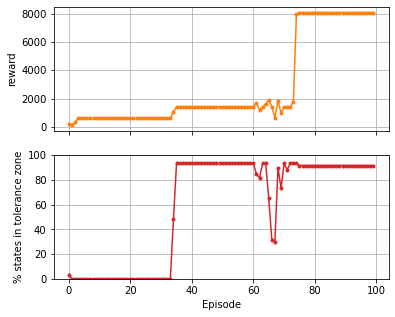

In [272]:
logger.plot()

### Evaluation

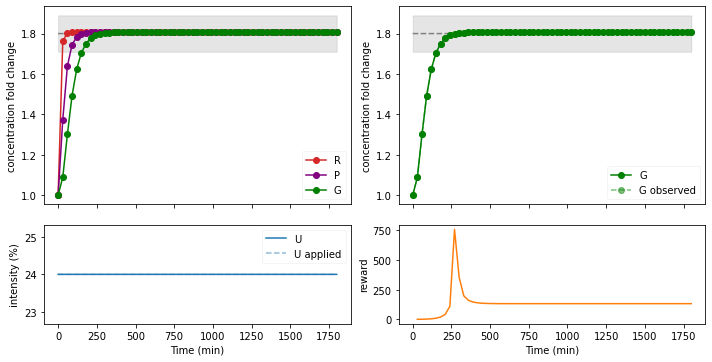

In [273]:
trainer.evaluate()

## Define Environment with Continuous Action Space

In [289]:
# reference trajectory
REF_INTENSITY = 1.8


# CRN environment
ENV = 'CRNContinuous-v0'

SAMPLING_RATE= 10  # in minutes

OBSERVATION_NOISE = 0.05
ACTION_NOISE = 1e-3
SYSTEM_NOISE = 1e-3

d_r = 0.0956
d_p = 0.0214
k_m = 0.0116
b_r = 0.0965
THETA = [d_r, d_p, k_m, b_r]

PERCENTAGE_THRES = 30 # in percentage

MODE = 'partially_observed'#'fully_observed'

EXTRA_INFO = False#True


# CRN step
SAMPLING_STEPS = 60  # 10 hours
REWARD_FUNC = 'negative_logae'

* Constant reference trajectory

In [290]:
ref_trajectory = drl.env.crn.ConstantRefTrajectory(
    scale=REF_INTENSITY,
)

* Define CRN environment with continous action space `CRNContinuou-v0`

In [291]:
env = drl.env.CRNEnv(
    ENV,
    DEVICE,
    ref_trajectory=ref_trajectory,
    sampling_rate=SAMPLING_RATE,
    observation_noise=OBSERVATION_NOISE,
    action_noise=ACTION_NOISE,
    system_noise=SYSTEM_NOISE,
    theta=THETA,
    percentage_thres=PERCENTAGE_THRES,
    observation_mode=MODE,
    extra_info=EXTRA_INFO,
)

In [292]:
env.seed(SEED)

In [47]:
env.reset()

for _ in range(SAMPLING_STEPS):
    env.step(
        env.action_sample(), 
        reward_func=REWARD_FUNC,
    )

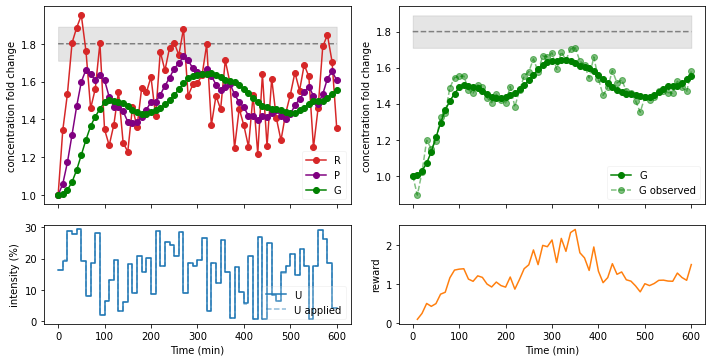

In [48]:
env.render(render_mode='dashboard')

## Constantly Applied Light Intensity in Continuous Action Space

In [293]:
# training
EPISODES = 100
TIMESTEPS = 60  # 10 hours

REWARD_FUNC = 'scaled_se'#'negative_logae'

# replay
EPISODE = -1

### Constant Agent

* Define constant agent for continuous action space

In [303]:
actor = drl.nn.ContinuousConstantActor(
    env.action_dim,
    1,
)

agent = drl.agent.DummyAgent(
    DEVICE,
    actor,
)

### Trainer for Constant Agent

In [304]:
trainer = drl.trainer.OffPolicyTrainer(
    env, 
    agent,
    n_episodes=EPISODES,
    n_timesteps=TIMESTEPS,
)

### Constantly Applying

In [305]:
logger = trainer(REWARD_FUNC)

### Replay

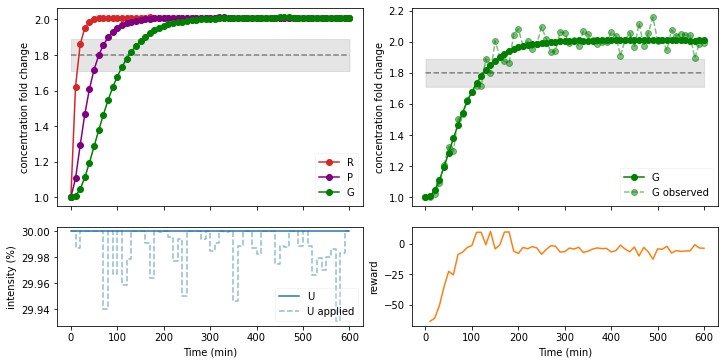

In [306]:
drl.utils.plotter.replay(env, logger, EPISODE)

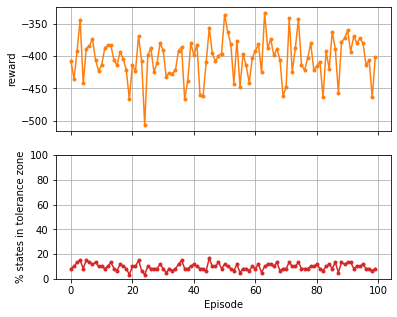

In [285]:
logger.plot()

## Random Walking in Continuous Action Space

In [42]:
# training
EPISODES = 100
TIMESTEPS = 60  # 10 hours

REWARD_FUNC = 'scaled_se'#'negative_logae'

# replay
EPISODE = -1

### Random Agent

* Define random agent for discrete action space

In [43]:
actor = drl.nn.ContinuousRandomActor(
    env.action_dim,
)

agent = drl.agent.DummyAgent(
    DEVICE,
    actor,
)

### Trainer for Random Agent

In [44]:
trainer = drl.trainer.OffPolicyTrainer(
    env, 
    agent,
    n_episodes=EPISODES,
    n_timesteps=TIMESTEPS,
)

### Random Walking

In [45]:
logger = trainer(REWARD_FUNC)

### Replay

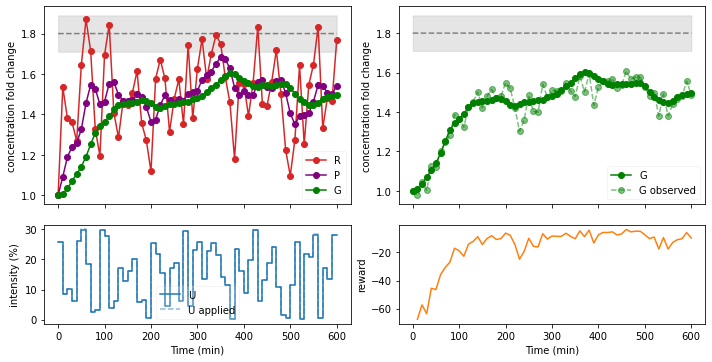

In [46]:
drl.utils.plotter.replay(env, logger, EPISODE)

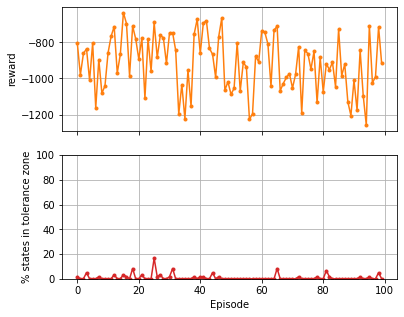

In [47]:
logger.plot()

## Control with Policy-Gradient Agent for Continuous Action Space

In [38]:
# training
EPISODES = 100
TIMESTEPS = 60  # 10 hours

REWARD_FUNC = 'scaled_se'#'negative_logae'

# replay
EPISODE = -1

### Agents

* DDPG agent

In [32]:
actor = drl.nn.Actor(
    env.state_dim,
    env.action_dim,
)

critic = drl.nn.Critic(
    env.state_dim,
    env.action_dim,
)

agent = drl.agent.DDPGAgent(
    DEVICE,
    actor,
    critic,
    exploration_noise=0.1,
    batch_size=128,
    burnin_size=16,
    learn_every=1,
    sync_every=4,
)

* TD3 agent

In [39]:
actor = drl.nn.Actor(
    env.state_dim,
    env.action_dim,
)

critic = drl.nn.TwinCritic(
    env.state_dim,
    env.action_dim,
    approximator_dims=(256,),
    param_sharing=False,
    hidden_dim=256,
    embedding_dims=(256,),
)

agent = drl.agent.TD3Agent(
    DEVICE,
    actor,
    critic,
    exploration_noise=0.1,
    batch_size=128,
    burnin_size=16,
    learn_every=1,
    sync_every=4,
)

### Off-Policy Trainer for Gradient-Policy Agent

* Define trainer for DDPG family

In [40]:
bs_scheduler = drl.utils.bs_scheduler.ConstantBS(
    agent,
)

trainer = drl.trainer.OffPolicyTrainer(
    env, 
    agent,
    n_episodes=EPISODES,
    n_timesteps=TIMESTEPS,
    bs_scheduler=bs_scheduler,
)

### Training

In [41]:
logger = trainer(REWARD_FUNC)

### Replay

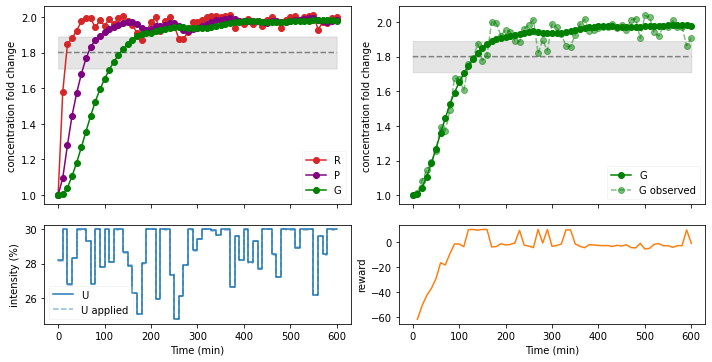

In [42]:
drl.utils.plotter.replay(env, logger, EPISODE)

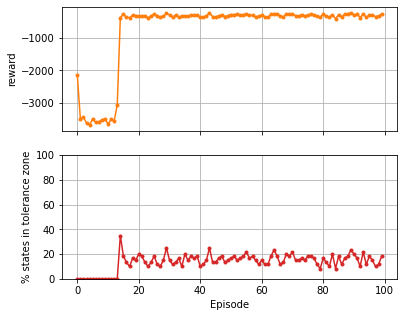

In [43]:
logger.plot()

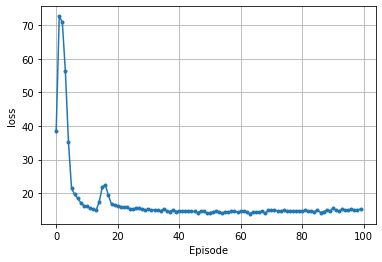

In [44]:
logger.plot_loss()